In [1]:
# Descarga de los datos:

#!pip install gdown
#!gdown --id 1whdnMdI6qkW-0kypplMFnWB2VWxyHUFF -O dsp.zip

In [2]:
# Descomprimir datos
#! unzip -o dsp.zip

# <span style="color:pink"> AUTORES </span>
 
* **<span style="color:pink"> Sebastián Kay Conde Lorenzo </span>**
* **<span style="color:pink"> Francisco Manuel López López </span>**

# <span style="color:red">¿DÓNDE ENCONTRAR LAS IMÁGENES, NOTAS Y DEMÁS?</span>

**<span style="color:red">PARA ENCONTRAR EL PROYECTO COMPLETO DE ESTOS NOTEBOOKS (INCLUYENDO LA ESTRUCTURA DE CARPETAS E IMÁGENES USADAS) POR FAVOR VISITAR ESTE [REPOSITORIO](https://github.com/cbasitodx/Medical_Image_Processing_Course)**</span>

## Características de la convolución

Uso de la convolución y kernels para preprocesar una imagen y resaltar características de la imagen o utilizar los resultados como nuevas características de la imagen.

In [3]:
#!pip install pydicom
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
from skimage.transform import resize

In [4]:
def read_dicom(file_path):
    metadata = dicom.dcmread(file_path)
    image_data = metadata.pixel_array
    return metadata, image_data

Leer la imagen

/home/seby/UPM/Signal/Images/imagen_medica/venv/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '04031e57794b9e8861e3c65e935f11d2'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 154
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 04031e57794b9e8861e3c65e935f11d2
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.3.4
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010,0040) Patient's Sex                       CS: 'M'
(0010,1010) Patient's Age                       AS: '054Y'
(0028,0002) Samples per Pixel                   US: 1
(0028,0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028,0008) Number of Frames                    IS: '1'
(0028,0010) Rows                                US: 3072
(0028,0011) Columns                             US: 

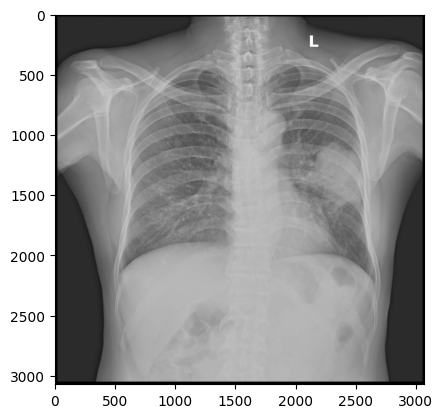

In [5]:
metadata, xray = read_dicom('imagenes/dsp/04031e57794b9e8861e3c65e935f11d2.dcm')
print(metadata)

plt.imshow(xray, cmap='gray')
plt.show()

In [6]:
def convolve(img: np.array, kernel: np.array) -> np.array:
  # Funtion for convolving an image with a kernel, it is not optimized

  # Dimensions of the image are reduced when convolution is applied
  # to avoid this, padding is used before convolution
  h = img.shape[0] - kernel.shape[0] + 1
  w = img.shape[1] - kernel.shape[1] + 1

  k_h, k_w  = kernel.shape[0], kernel.shape[1]

  # 2D array of zeros
  convolved_img = np.zeros(shape=(h, w))

  # Iterate over the rows
  for i in range(h):
    # Iterate over the columns
    for j in range(w):
      # img[i, j] = individual pixel value
      # Get the current matrix
      mat = img[i:i+k_h, j:j+k_w]

      # Apply the convolution - element-wise multiplication and summation of the result
      # Store the result to i-th row and j-th column of our convolved_img array
      convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
  return convolved_img

Vamos a realizar algún procesamiento de imágenes.

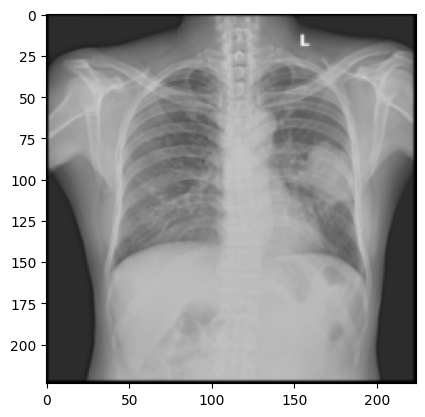

In [7]:
# We convert image into grayscale and normalize to [0,1] range
im = xray / np.max(xray)

im = resize(im, (224, 224)) # resize image to 224x224, it works also with RGB

plt.imshow(im, cmap='gray')
plt.show()

#### Kernel para extracción de bordes

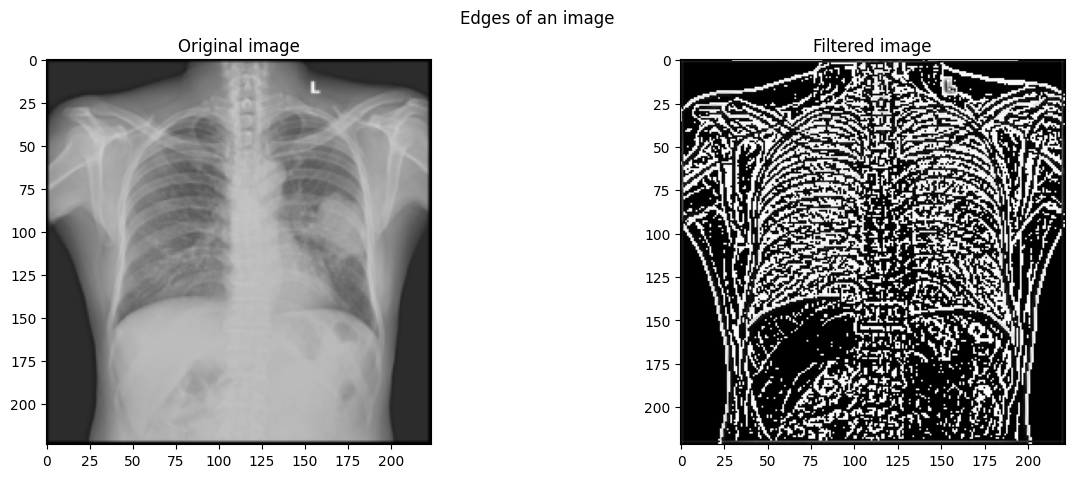

In [8]:
kernel = np.ones((3, 3)) * -1.0
kernel[1, 1] = 8.0

edges_img = convolve(im / 255, kernel)
# Normalize output image for visualization
edges_img = ((edges_img / edges_img.max()) * 255).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Edges of an image')
ax1.imshow(im, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(edges_img, cmap='gray')
ax2.set_title('Filtered image')
plt.show()

Otros kernels se pueden visualizar aquí: https://setosa.io/ev/image-kernels/

## Actividad 1: Probar dos kernels, sobre la imagen original y otra con el contraste mejorado.

### Respuesta:
Podemos probar dos kernels: Uno de Sobel X + Sobel Y, y el filtro Laplaciano. Ambos detectan border, por lo que podemos compararlos.

Luego, en cuanto a mejorar el contraste la imágen, podemos usar la técnica de equalización de histograma con el fin de mejorar el contraste de la misma.


In [9]:
def equalize_hist(image):
    # Scale the image to values between 0-255
    image = (image * 255).astype(np.uint8)
    # Compute the normal histogram
    histogram, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    # Compute the cumulative histogram
    cumulative_histogram = np.cumsum(histogram)
    # Normalize the cumulative histogram
    cumulative_histogram_normalized = cumulative_histogram / cumulative_histogram[-1]
    # Create an intensity mapping table
    new_intensities = np.round(cumulative_histogram_normalized * 255).astype(np.uint8)
    # Apply the mapping table to the original image
    equalized_image = new_intensities[image]
    return equalized_image

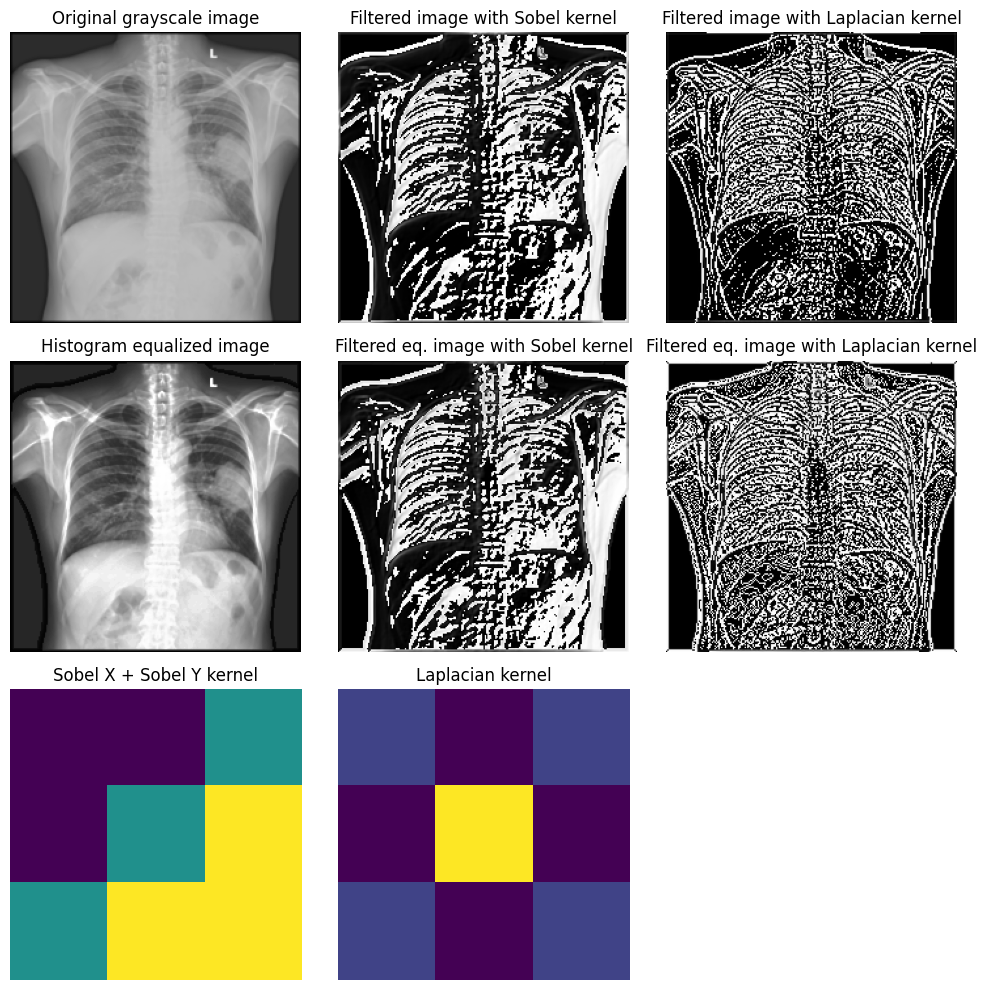

In [10]:
# Empezamos creando los kernels
sobel_X : np.ndarray = np.array([[-1,  0,  1],
                                 [-2,  0,  2],
                                 [-1,  0,  1]])

sobel_Y : np.ndarray = np.array([[-1, -2, -1],
                                 [ 0,  0,  0],
                                 [ 1,  2,  1]])

sobel_combined_kernel : np.ndarray = sobel_X + sobel_Y

laplacian_kernel : np.ndarray = np.array([[ 0, -1,  0],
                                          [-1,  4, -1],
                                          [ 0, -1,  0]])

# Obtenemos la imagen con su histograma equalizado (es decir, con su contraste mejorado)
eq_im = equalize_hist(im)

# Aplicamos la convolucion con los kernels
sobel_img     = convolve(im, sobel_combined_kernel)
laplacian_img = convolve(im, laplacian_kernel)

eq_sobel_img     = convolve(eq_im, sobel_combined_kernel)
eq_laplacian_img = convolve(eq_im, laplacian_kernel)

# Normalizamos las imagenes convolucionadas para su visualizacion
sobel_img     = ((sobel_img / sobel_img.max()) * 255).astype(np.uint8)
laplacian_img = ((laplacian_img / laplacian_img.max()) * 255).astype(np.uint8)

eq_sobel_img     = ((eq_sobel_img / eq_sobel_img.max()) * 255).astype(np.uint8)
eq_laplacian_img = ((eq_laplacian_img / eq_laplacian_img.max()) * 255).astype(np.uint8)

# Visualizamos
N_ROWS = 3
N_COLS = 3
plt.figure(figsize=(10,10))

plt.subplot(N_ROWS,N_COLS,1)
plt.title("Original grayscale image")
plt.imshow(im, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,2)
plt.title("Filtered image with Sobel kernel")
plt.imshow(sobel_img, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,3)
plt.title("Filtered image with Laplacian kernel")
plt.imshow(laplacian_img, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,4)
plt.title("Histogram equalized image")
plt.imshow(eq_im, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,5)
plt.title("Filtered eq. image with Sobel kernel")
plt.imshow(eq_sobel_img, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,6)
plt.title("Filtered eq. image with Laplacian kernel")
plt.imshow(eq_laplacian_img, cmap='gray')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,7)
plt.title("Sobel X + Sobel Y kernel")
plt.imshow(sobel_combined_kernel, cmap='viridis')
plt.axis('off')

plt.subplot(N_ROWS,N_COLS,8)
plt.title("Laplacian kernel")
plt.imshow(laplacian_kernel, cmap='viridis')
plt.axis('off')


plt.tight_layout()
plt.show()

## Características de las redes neuronales convolucionales (CNN):

Las CNN siguen el mismo principio de convolución con los kernels que se muestran anteriormente. Sin embargo, los kernels son autoaprendidos. La red neuronal aprende los mejores kernels para extraer características.

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
import requests

try:
  from torchinfo import summary
except:
  !pip install -U torchinfo
  from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Enlace interesante para explorar redes neuronales convolucionales: https://poloclub.github.io/cnn-explainer/

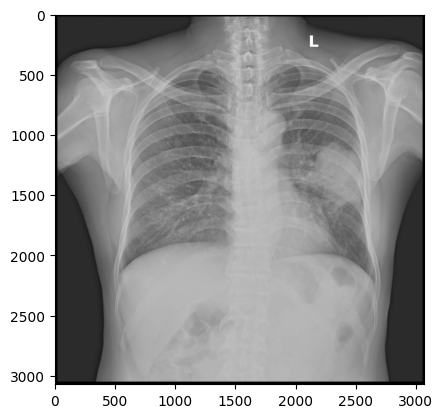

In [12]:
metadata, xray = read_dicom('imagenes/dsp/04031e57794b9e8861e3c65e935f11d2.dcm')
plt.imshow(xray, cmap='gray')
plt.show()

#### Preprocesado

In [13]:
def grayscale_to_rgb(img):
    img = np.repeat(np.expand_dims(img, -1), 3, axis=2) # Repeat grayscale channel 3 times
    return img

def preprocess_image(img):
    # preprocessing
    x = np.expand_dims(img, axis=0) # batch x width x height x channels
    x = np.rollaxis(x, 3, 1) # batch x channels x width x height
    x = x.astype(np.float32)
    # Normalize the image (mean 0 and std 1)
    x = x - x.mean()
    x = x / x.std()
    return x

img = grayscale_to_rgb(xray)

# image modifications


img = resize(xray, output_shape=(224, 224),
             preserve_range=True) # resize image
img = (img / np.max(img) * 255).astype(np.uint8)
img = grayscale_to_rgb(img)
x = preprocess_image(img)

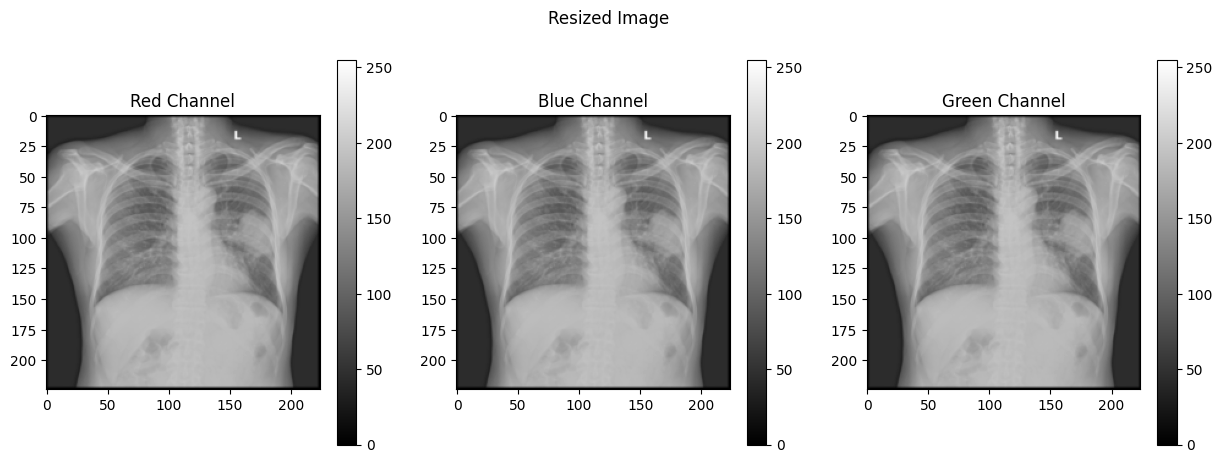

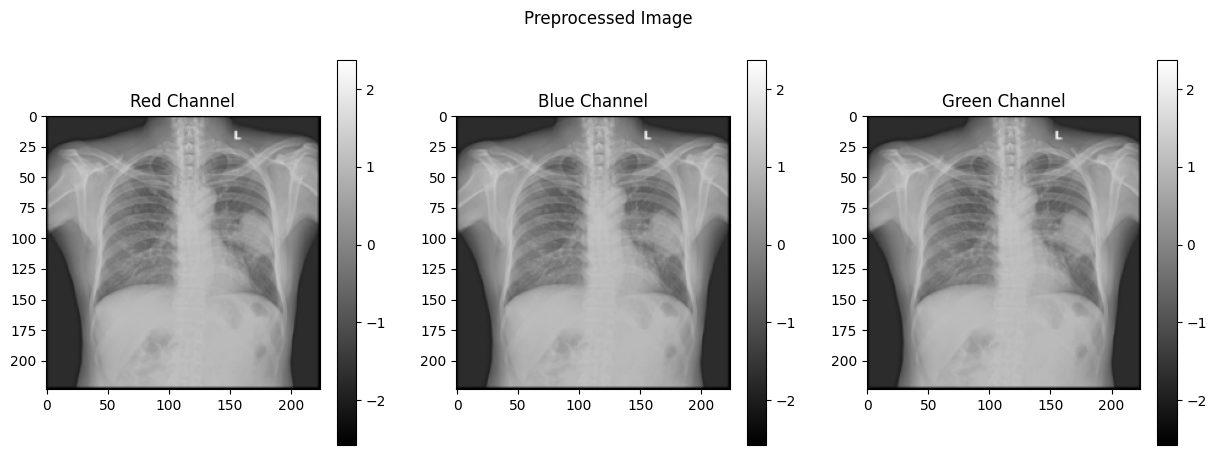

In [14]:
# Plot images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Resized Image')
im1 = ax1.imshow(img[:,:,0], cmap='gray')
plt.colorbar(im1, ax=ax1) # TODO: set the same scale
ax1.set_title('Red Channel')
im2 = ax2.imshow(img[:,:,1], cmap='gray', vmin=0, vmax=255)
plt.colorbar(im2, ax=ax2)
ax2.set_title('Blue Channel')
im3 = ax3.imshow(img[:,:,2], cmap='gray', vmin=0, vmax=255)
plt.colorbar(im3, ax=ax3)
ax3.set_title('Green Channel')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Preprocessed Image')
im1 = ax1.imshow(np.squeeze(x)[0,:,:], cmap='gray')
plt.colorbar(im1, ax=ax1)
ax1.set_title('Red Channel')
im2 = ax2.imshow(np.squeeze(x)[1,:,:], cmap='gray')
plt.colorbar(im2, ax=ax2)
ax2.set_title('Blue Channel')
im3 = ax3.imshow(np.squeeze(x)[2,:,:], cmap='gray')
plt.colorbar(im3, ax=ax3)
ax3.set_title('Green Channel')
plt.show()

In [15]:
# Download pretrained model
model = models.vgg16(weights='DEFAULT')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Summarize structure of the network
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

### Filtros de Convolución

In [17]:
# Function to visualize the filters of a convolution layer
def filter_map(model, image, layer='conv_1'):
  layers = {'conv_1': 1, 'conv_2': 3, 'conv_3': 6,
          'conv_4': 8, 'conv_5': 11, 'conv_5': 13,
          'conv_6': 15, 'conv_7': 18, 'conv_8': 20,
          'conv_9': 22, 'conv_10': 25, 'conv_11': 27,
          'conv_12': 29}
  assert layer in layers, 'layer not found'

  filters = model.features[layers[layer] - 1].weight
  num_filters = filters.size(0) if filters.size(0) < 64 else 64
  plt.figure(figsize=(20, 20))
  for i in range(num_filters):
    plt.subplot(num_filters//8, 8, i+1)
    plt.imshow(filters[i, 0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
  plt.show()

Visualicemos los filtros de la primera convolución.

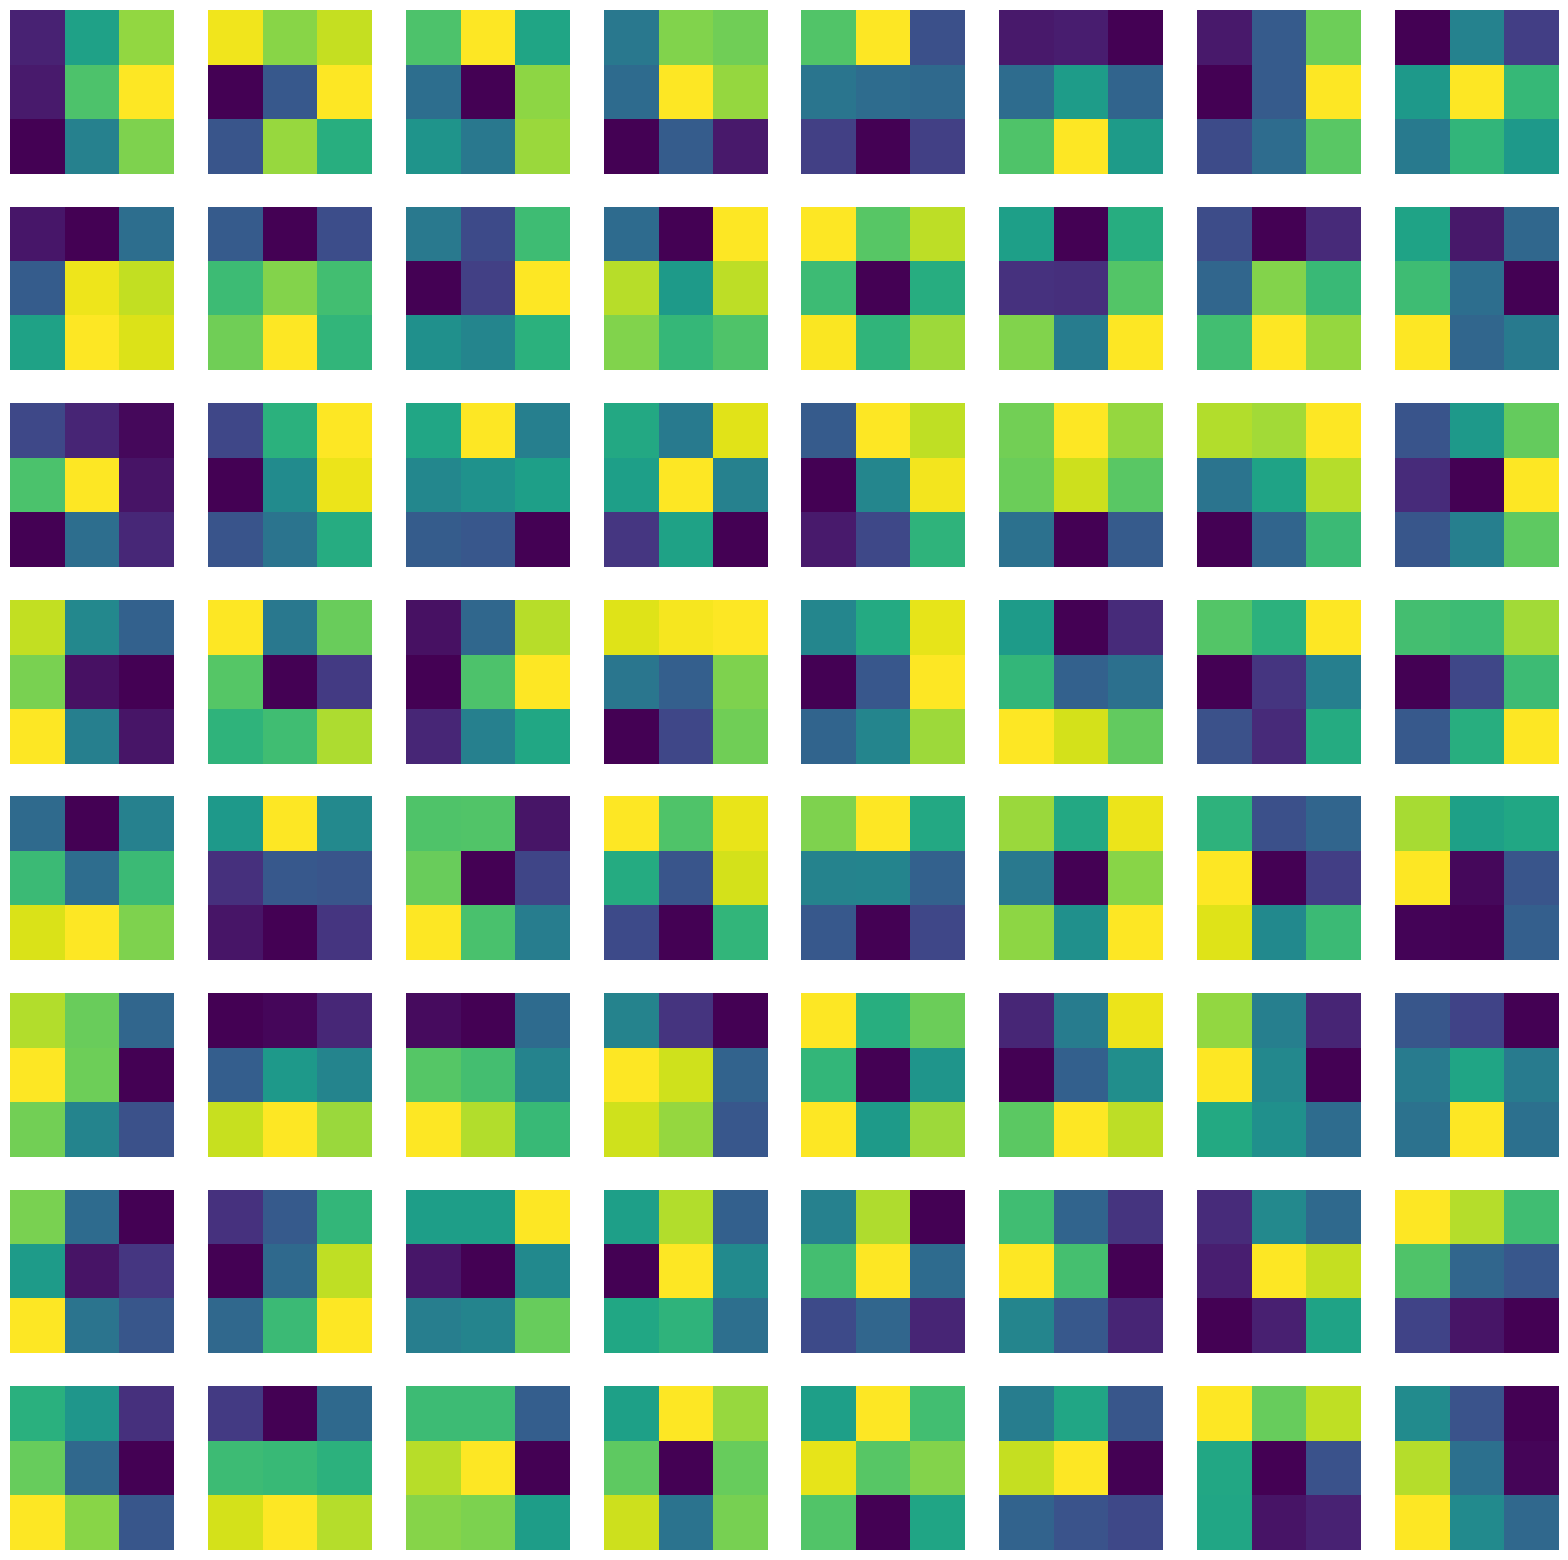

In [18]:
image = torch.from_numpy(x).float()

filter_map(model, image, 'conv_1')

#### Mapas de características de una red preentrenada.

In [19]:
# Function to visualize the feature (activation) maps of a CNN

def feature_map(model, image, layer='conv_1'):
  layers = {'conv_1': 1, 'conv_2': 3, 'conv_3': 6,
          'conv_4': 8, 'conv_5': 11, 'conv_5': 13,
          'conv_6': 15, 'conv_7': 18, 'conv_8': 20,
          'conv_9': 22, 'conv_10': 25, 'conv_11': 27,
          'conv_12': 29}
  assert layer in layers, 'layer not found'

  feat_maps = model.features[:layers[layer]](image).detach().squeeze()
  num_feat_maps = feat_maps.size(0) if feat_maps.size(0) < 64 else 64
  plt.figure(figsize=(20, 20))
  for i in range(num_feat_maps):
    plt.subplot(num_feat_maps//8, 8, i+1)
    plt.imshow(feat_maps[i].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
  plt.show()


Visualicemos los mapas de características de la 1ra convolución.

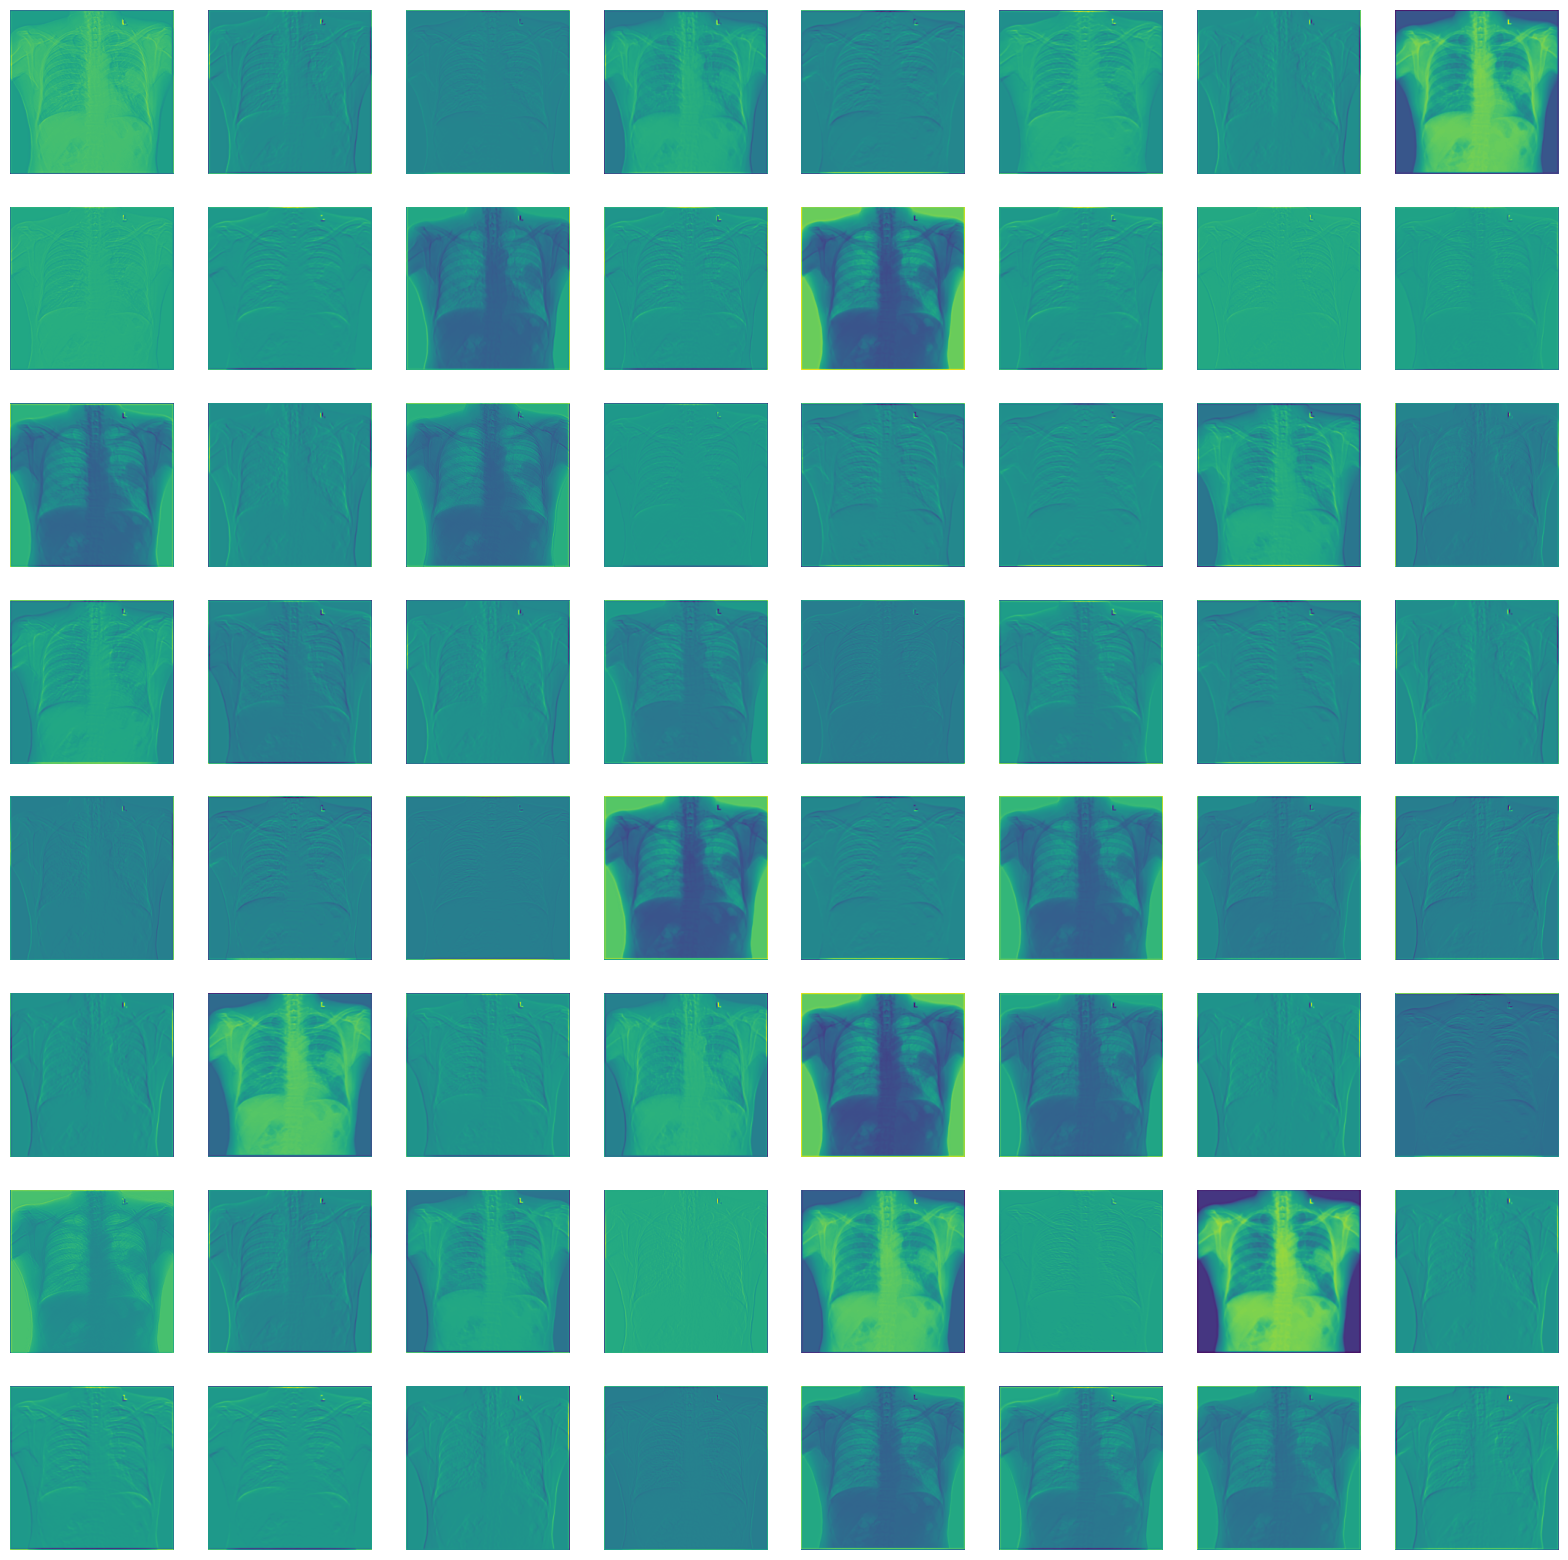

In [20]:
if device.type == 'cuda':
  image = torch.from_numpy(x).float().to('cuda')
else:
  image = torch.from_numpy(x).float()

feature_map(model, image, layer='conv_1')

Visualicemos los mapas de características de la convolución 11.

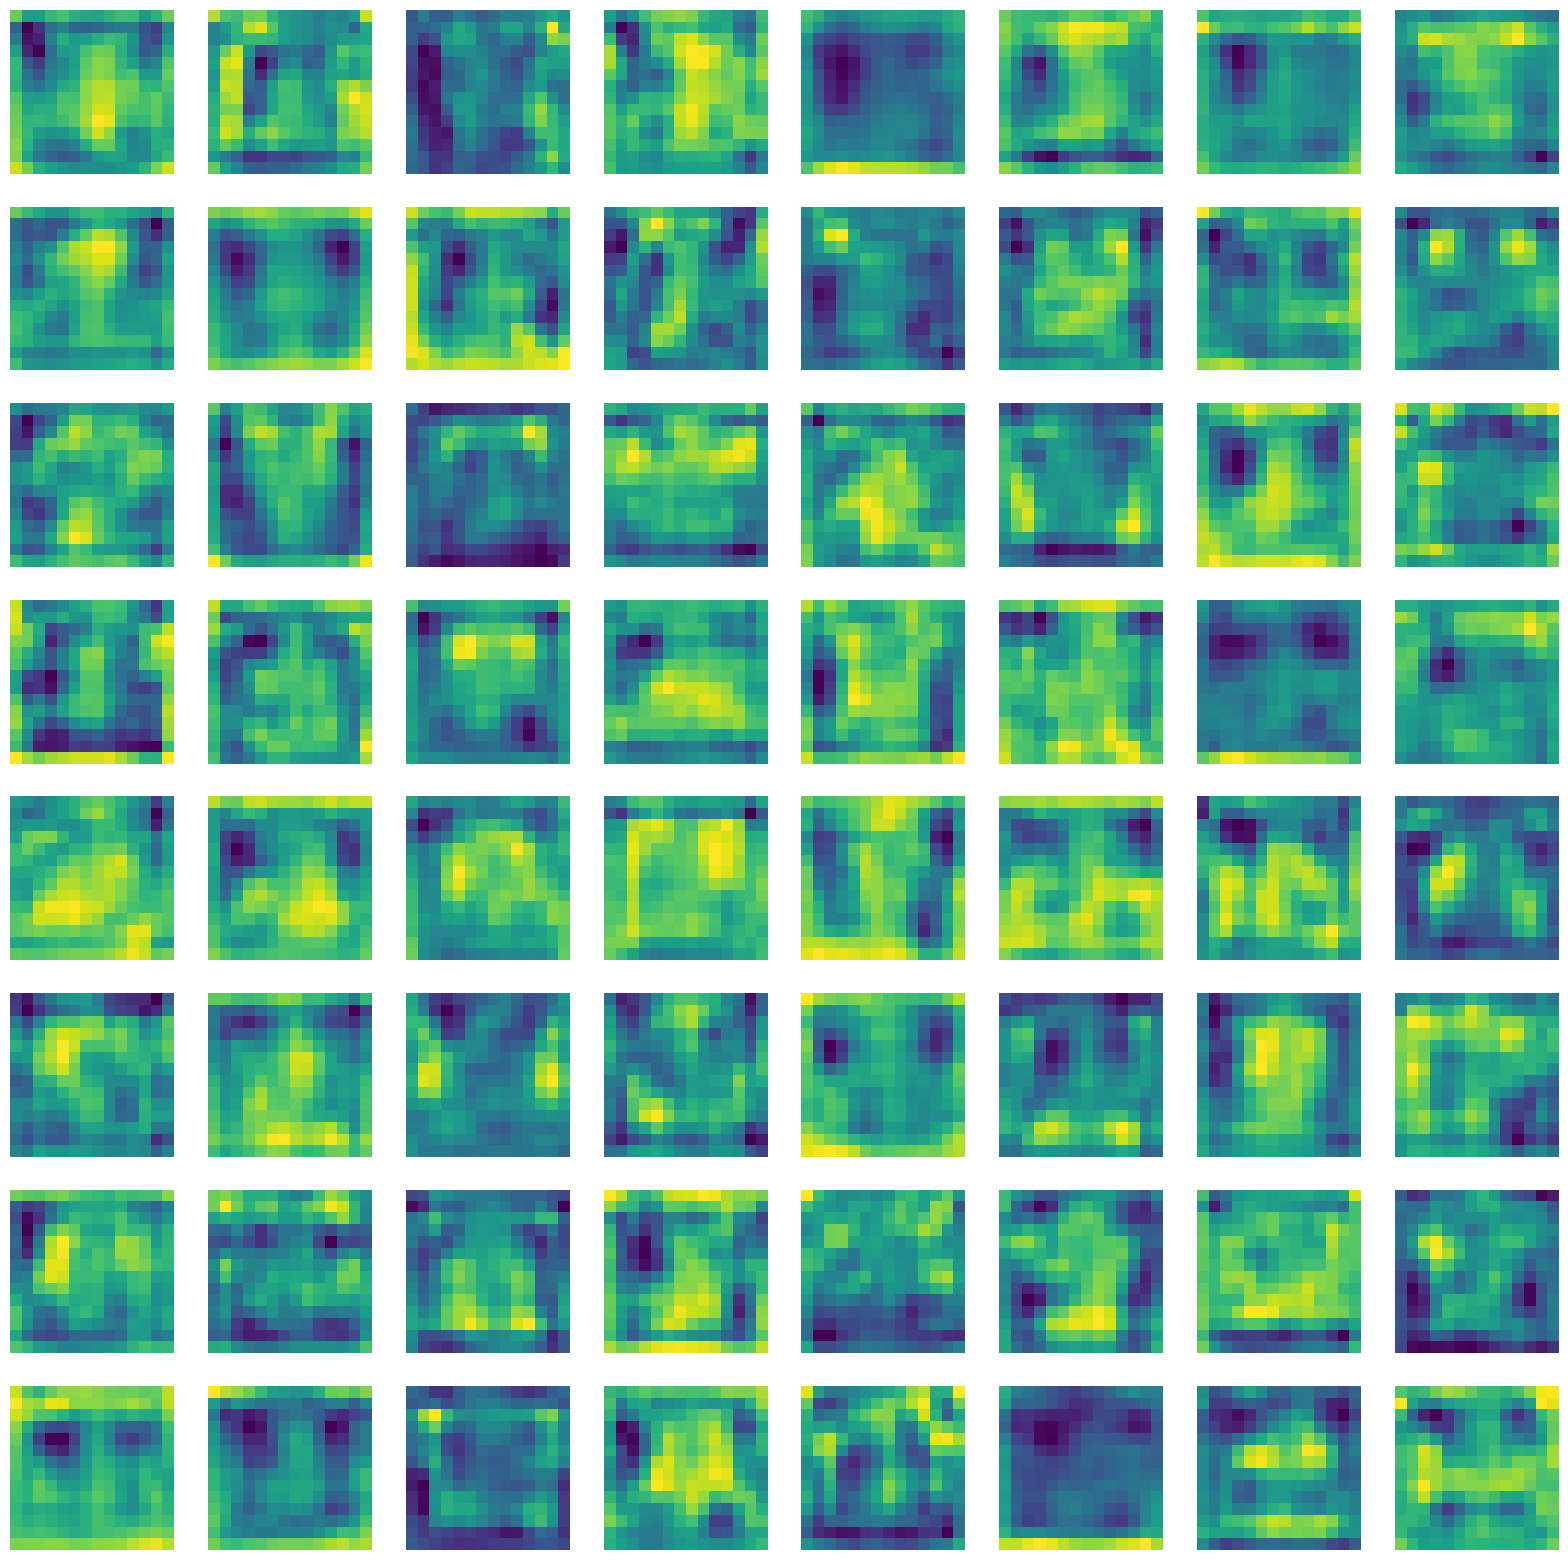

In [21]:
if device.type == 'cuda':
  image = torch.from_numpy(x).float().to('cuda')
else:
  image = torch.from_numpy(x).float()

feature_map(model, image, layer='conv_11')

## Actividad 2: Visualizar mapas de características de otra imagen

### Respuesta:
Cargamos otra imagen y repetimos el proceso anterior

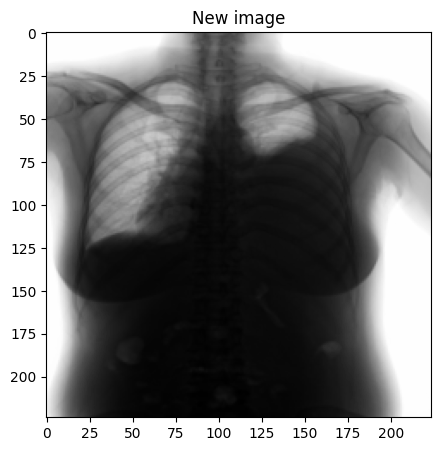

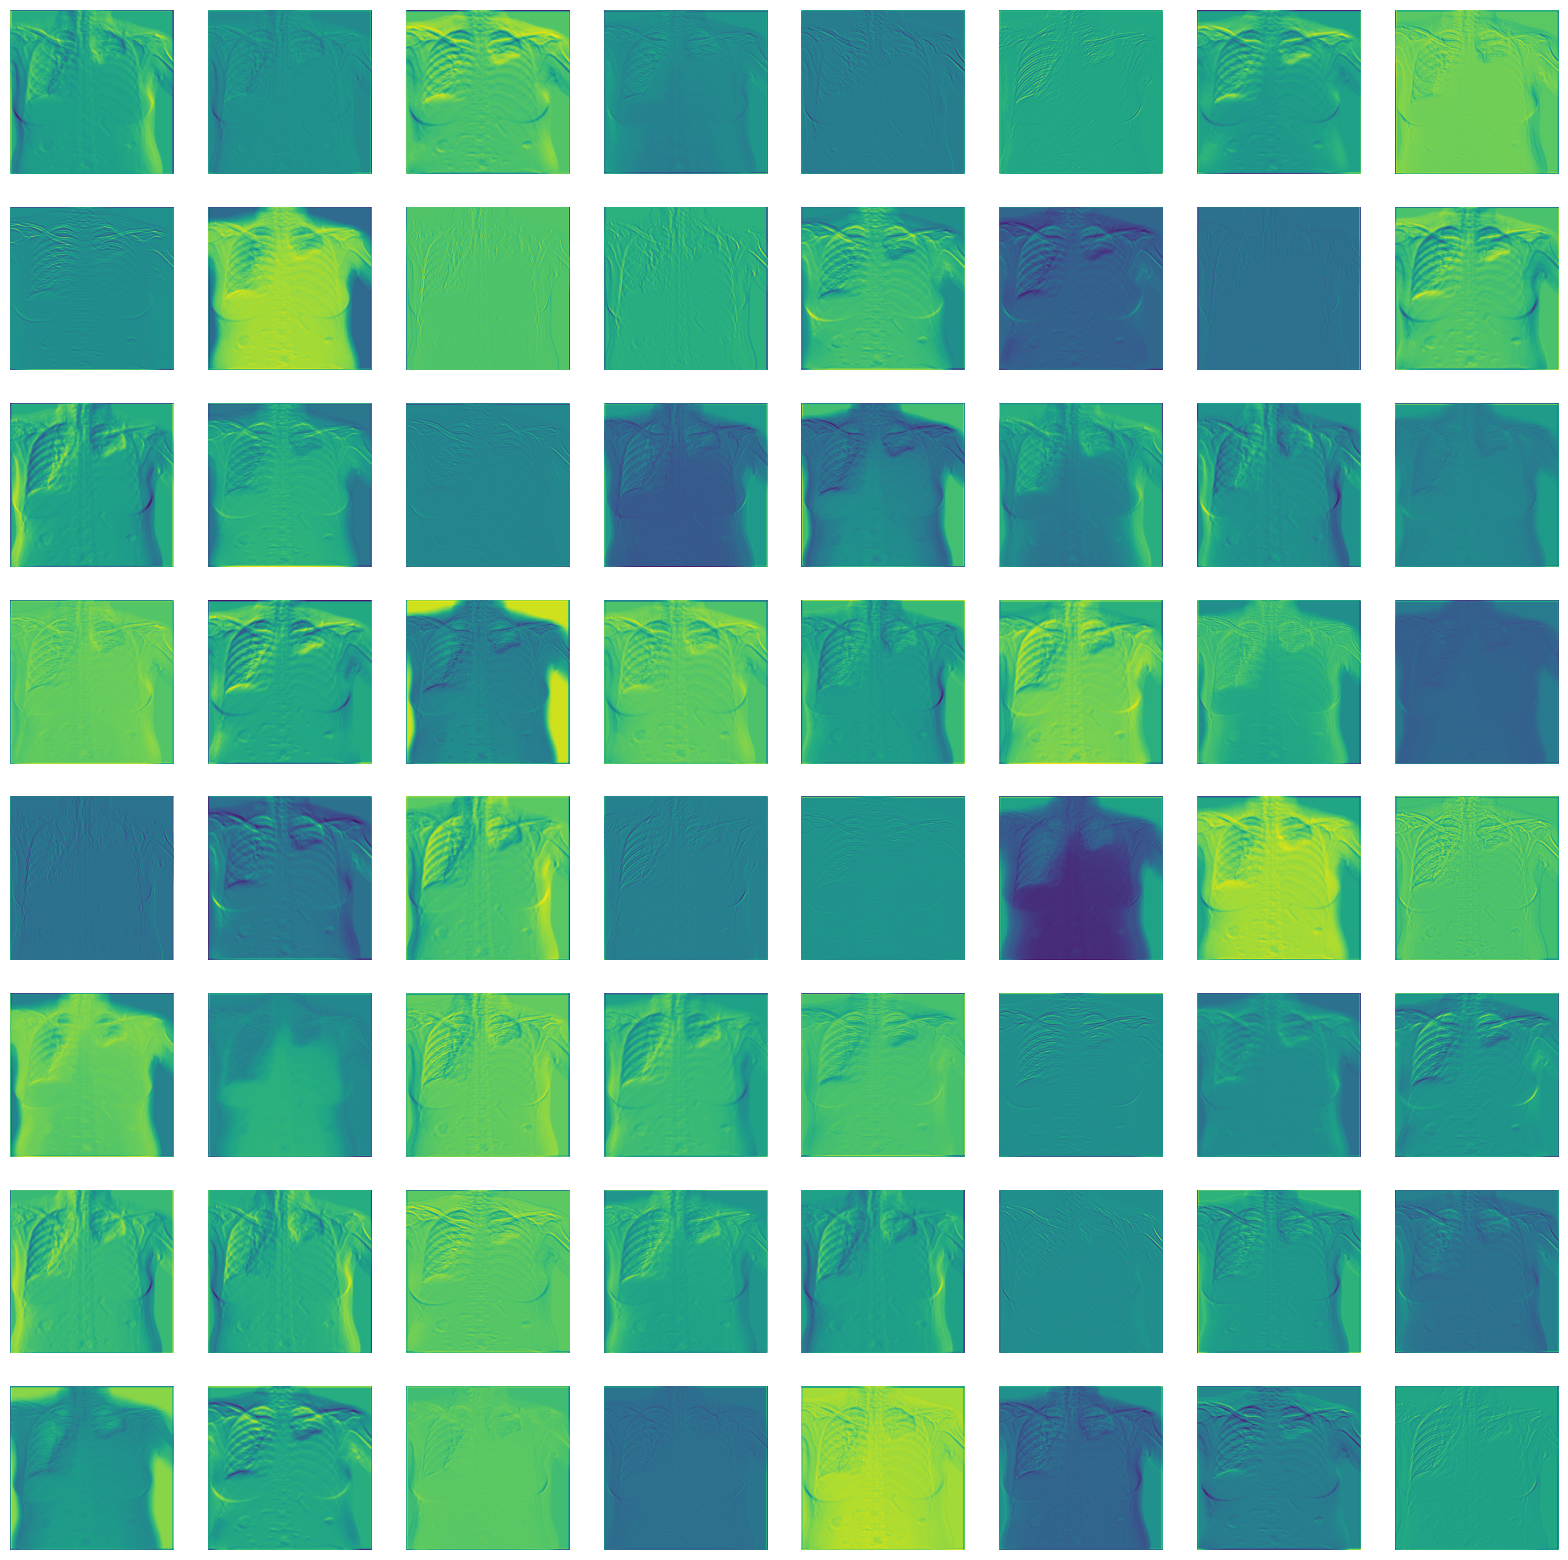

In [22]:
# Cargamos la imagen
_, x_ray2 = read_dicom('imagenes/dsp/0a0ac65c40a9ac441651e4bfbde03c4e.dcm')

# Transformamos los valores de la imagen a valores en el intervalo [0,1]
x_ray2 = x_ray2 / np.max(x_ray2)

# Le aplicamos un pre-procesado a la imagen
x_ray2 = resize(x_ray2, output_shape=(224, 224),
             preserve_range=True)
x_ray2 = (x_ray2 / np.max(x_ray2) * 255).astype(np.uint8)
x_ray2 = grayscale_to_rgb(x_ray2)
x_ray2 = preprocess_image(x_ray2)

# Mostramos la imagen
plt.figure(figsize=(15,5))
plt.imshow(x_ray2[0][0], cmap='gray')
plt.title('New image')
plt.show()

# Ahora mostramos los mapas de caracteristicas de la nueva imagen
# Los visualizaremos de la segunda capa
if device.type == 'cuda':
  x_ray2 = torch.from_numpy(x_ray2).float().to('cuda')
else:
  x_ray2 = torch.from_numpy(x_ray2).float()

feature_map(model, x_ray2, layer='conv_2')

### Feature extraction with VGG

In [23]:
def extract_features(model, image, device):
    model_features = model.features
    features = model_features(torch.from_numpy(image).float().to(device)).flatten()
    if device.type == 'cuda':
        features = features.detach().cpu().numpy()
    else:
        features = features.detach().numpy()
    return features

In [24]:
feat = extract_features(model, x, device) # feature extraction from one image
feat

array([0., 0., 0., ..., 0., 0., 0.], shape=(25088,), dtype=float32)

## Actividad 3:
1. Seleccionar 3 tipos de imágenes (clases) utlizando como referencia el archivo csv (dentro del directorio que contiene las imágenes). Una de ellas debe ser "no finding".
2. Aleatoriamente selecciona 1 imagen de cada tipo. Esta será llamada imagen de test y el resto se llamara train.
3. Calcula las características de todas las imágenes de train y almacénalas. Mantén un registro de la clase a la que pertenece cada imagen.
4. Calcula las características para las imágenes de test.
5. Calcula la diferencia entre una imagen test respecto a todas las imágenes train. Para ello utiliza la distancia euclidea.
6. Estima cuáles son las 3 imágenes más cercanas en el conjunto de imágenes train. La clase de la mayoría será la correspondiente a la imagen de test.
7. Verifica si la clase obtenida en el paso 6 corresponde con la clase original de la imagen de test.
8. Repite 5-7 para cada imagen de test.

Este método es una algoritmo de machine learning conocido como k-NN, k nearest neighbors. Donde k en nuestro caso es 3.

### Respuesta:

Con el espiritu de programar un *k-nearest neighbors* de manera genérica (que acepte cualquier *k* y cualesquiera clases), programaremos funciones clave por cada apartado, y luego las uniremos en una sola!

### 1. Seleccionar 3 tipos de imágenes (clases) utlizando como referencia el archivo csv (dentro del directorio que contiene las imágenes). Una de ellas debe ser "no finding".

En el caso de nuestro grupo, utilizaremos las imágenes de las clases **"Nodule/Mass"**, **"Cardiomegaly"** y **No finding**.

In [25]:
import pandas as pd

In [26]:
# Empezamos cargando el csv que tiene la informacion necesaria
df : pd.DataFrame = pd.read_csv("./imagenes/dsp/dataset_dsp.csv")

# Lo visualizamos
df

image_id        class_name
0   50a418190bc3fb1ef1633bf9678929b3        No finding
1   21a10246a5ec7af151081d0cd6d65dc9        No finding
2   063319de25ce7edb9b1c6b8881290140        No finding
3   5550a493b1c4554da469a072fdfab974        No finding
4   869f39afbdd8783b531530942eda8bad        No finding
..                               ...               ...
65  928076ee487f027f64e040389fc91725  Pleural effusion
66  bd82bfb604a82629f08b99b1c165db35  Pleural effusion
67  124ec853c372fcf7f4428b26b32be62f  Pleural effusion
68  8af84125f707b873c506f65de72e02e4  Pleural effusion
69  5fd4c67e23e05c603525dae871ee1077  Pleural effusion

[70 rows x 2 columns]

In [27]:
# Visualizamos los valores unicos de la columna "class_name"
df["class_name"].unique()

array(['No finding', 'Aortic enlargement', 'Pleural thickening',
       'Pulmonary fibrosis', 'Cardiomegaly', 'Nodule/Mass',
       'Pleural effusion'], dtype=object)

In [28]:
# Hacemos una función que, dado un conjunto de clases, nos devuelva una lista con los path de las imagenes que pertenecen a esas clases (en el mismo orden en el que se han indicado las clases)
# Con este metodo ya podremos obtener las imagenes de cualesquiera 3 clases
def get_images_path_belonging_to_class(im_path : str, 
                                       extension : str, 
                                       df : pd.DataFrame, 
                                       *args) -> list[list[str]]:
    '''
        ===
        Summary
        ===
        
        Dado un dataframe con nombres de imagenes y sus clases asociadas, devuelve la ruta a las imagenes de las clases indicadas

        ===
        Args
        ===

        * im_path   : ruta a la carpeta donde estan las imagenes (ej. "./imagenes/dsp/")
        * extesnion : extension de las imagenes (ej. ".dsp")
        * df        : Objeto de tipo DataFrame de pandas que contenga dos columnas: "image_id" con el nombre de la imagen, y "class_name" con su clase
        * args      : Nombres de las clases para las cuales queremos hallar sus imagenes separadas por comas

        ===
        Return
        ===

        Retorna una lista de listas de strings. Cada lista tiene las rutas completas a las imagenes de una clase.
        El resultado viene ordenado por como se hayan introducido las clases (es decir, si por ejemplo se puso primero "A" y luego "B", la lista resultante tendrá
        primero una lista con las rutas a las imagenes de clase "A", y luego otra con las rutas a las imagenes de clase "B")
    '''
    images_paths : list[list[str]] = []
    for class_name in args:
        images_paths.append(list(df[df["class_name"] == f"{class_name}"]["image_id"].map(lambda x : im_path + x + extension)))
    
    return images_paths

### 2. Aleatoriamente selecciona 1 imagen de cada tipo. Esta será llamada imagen de test y el resto se llamara train.

Gracias a la función hecha anteriormente, hacer esto se reduce a samplear aleatoriamente de la lista de imagenes que retorna la función


In [29]:
import random

In [30]:
# Fijamos una semilla
SEED : int = 4
random.seed(SEED)

In [31]:
# Fijamos las clases a usar
clases = {'Class 1' : 'Cardiomegaly', 'Class 2' :'Nodule/Mass', 'Class 3' :'No finding'}

# Condensamos la funcionalidad solicitada en una funcion
def split_into_train_test(clases : dict,
                          n_test  : int,
                          **kwargs) -> tuple[list[str]]:
    '''
        ===
        Summary
        ===
        
        Dado un conjunto de paths a imagenes, devuelve un diccionario que asocia a cada clase su split en entrenamiento y validacion

        ===
        Args
        ===
        * clases    : Diccionario (de la forma "Class i" : [nombre de la clase]) 
                      de las clases para las cuales queremos hacer el split en test & train de las imagenes de dichas clases.
                      ADVERTENCIA: La 'i' debe empezar en 1
        * n_test    : longitud de la lista con las rutas a las imagenes de validacion
        * kwargs    : 'keyword arguments'. Cada uno de estos argumentos debe tener un nombre de la forma "class_i_paths", 
                      y sera una lista de strings con las rutas a las imagenes de clase i-esima. ADVERTENCIA: La 'i' debe ir de 1 a len(clases)

        ===
        Return
        ===

        Retorna un diccionario de diccionarios de listas de strings. 
        El diccionario es de la forma:
        {
            Class i: {
                Test:  test_i,
                Train: train_i
            },
            ...
        } 
        
        Donde test_i es una lista de strings con la ruta a las imagenes que se usaran para validar
        y train_i una lista de strings con la ruta a las imagenes que se usaran para entrenar
    '''

    # Sampleamos aleatoriamente n_tests imagenes de cada clase. Con esto obtenemos el conjunto de testing
    # Luego, excluyendo la imagen sampleada anteriormente del total de paths, obtenemos el conjunto de training
    split : dict[dict[list[str]]] = {}
    for i in range(1, len(clases)+1):
        class_i_paths = kwargs[f"class_{i}_paths"]
        
        class_i_test  : list[str] = [class_i_paths[random.randint(0, len(class_i_paths) - 1)] for _ in range(n_test)]
        class_i_train : list[str] = list(set(class_i_paths) - set(class_i_test))

        split[f"Class {i}"] = {"Test" : class_i_test, "Train" : class_i_train}

    return split

### 3. Calcula las características de todas las imágenes de train y almacénalas. Mantén un registro de la clase a la que pertenece cada imagen.

& 


### 4. Calcula las caracterísitcas para las imágenes de test.

Nuevamente, haremos una función que encapsule estas funcionalidades de manera genérica

In [32]:
def get_features(test_train_dict : dict[dict[list[str]]],
                 model           : callable,
                 device          : torch.device) -> tuple[list[np.ndarray]]:
    '''
        ===
        Summary
        ===
        Dado un diccionario de la forma:

        {
            Class i: {
                Test:  test_i,
                Train: train_i
            },
            ...
        } 
        
        Donde test_i es una lista de strings con la ruta a las imagenes que se usaran para validar
        y train_i una lista de strings con la ruta a las imagenes que se usaran para entrenar

        Devuelve un diccionario con las features de las imagenes de test y train

        ===
        Args
        ===
        * test_train_dict: Diccionario que, por cada clase, contiene las imagenes de validacion y entrenamiento a usar
        * model          : Modelo de Deep Learning que usaremos para extraer los vectores de features
        * device         : Dispositivo (cuda o cpu)

        ===
        Return
        ===

        Retorna un diccionario de diccionarios de listas de arrays de numpy. 
        El diccionario es de la forma:
        {
            Class i: {
                Test:  feat_test_i,
                Train: feat_train_i
            },
            ...
        } 
        
        Donde feat_test_i es una lista de arrays de numpy donde cada array de numpy es un vector de features de uno de los ejemplos de validacion.
        Por otro lado, feat_train_i es lo mismo pero para ejemplos de entrenamiento.
        
    '''
    # Diccionario a retornar
    feats : dict[dict[list[np.ndarray]]] = {}

    # Esta funcion devuelve el vector de features para una sola imagen
    def get_features_individually(im_path : str, model : callable, device : torch.device) -> tuple[np.ndarray]:
        # Cargamos la imagen
        _, im  = read_dicom(im_path)

        # Transformamos los valores de la imagen a valores en el intervalo [0,1]
        im  = im / np.max(im)

        # Le aplicamos un pre-procesado a la imagen para que sea compatible con el modelo
        im = resize(im, output_shape=(224, 224), preserve_range=True)
        im = (im / np.max(im) * 255).astype(np.uint8)
        im = grayscale_to_rgb(im)
        im = preprocess_image(im)

        # Devolvemos las features de la imagen
        return extract_features(model, im, device)

    # Rellenamos el diccionario
    for key, value in test_train_dict.items():
        feats[key] = {
            "Test" : [get_features_individually(test_path, model, device) for test_path in value["Test"]],
            "Train" : [get_features_individually(train_path, model, device) for train_path in value["Train"]]}
    
    return feats

### 5. Calcula la diferencia entre una imagen test respecto a todas las imágenes train. Para ello utiliza la distancia euclidea.

&


### 6. Estima cuáles son las 3 imágenes más cercanas en el conjunto de imágenes train. La clase de la mayoría será la correspondiente a la imagen de test.

&

### 7. Verifica si la clase obtenida en el paso 6 corresponde con la clase original de la imagen de test.

&

### 8. Repite 5-7 para cada imagen de test.

In [33]:
import heapq
from collections import Counter

In [34]:
# Finalmente, hacemos la funcion de k-NN
def k_nn(k : int,
         im_path   : str, 
         extension : str, 
         df        : pd.DataFrame, 
         n_test    : int,
         model     : callable,
         device    : torch.device,
         *args) -> dict:
    '''
        ===
        Summary
        ===
        Dado un dataset con imagenes y sus clases, y un conjunto de clases selectas: Se filtran las imagenes del dataset pertenecientes
        a esas clases y se dividen en entrenamiento y validacion (tantas de validacion como indique {n_test}).

        Luego, las imagenes de validacion se clasifican utilizando el metodo de k-Nearest Neighbors. Los vectores necesarios para el metodo
        se obtienen de las features de {model}.

        Esta clasificación se retorna como un diccionario con la forma:

        k_nn_dict = {test_img_path : 
                {
                    "True Class": class, 
                    "Features": features, 
                    "k Best": k_best_imgs_path, 
                    "k Best Classes": k_best_classes,
                    "k Best Distances" : k_best_distances,
                    "Predicted Class": predicted_class
                },
                    test_image_path_2 : 
                {
                    ...
                },
                ...
            }

        ===
        Args
        ===
        * k         : Número de vecinos que se tendran en cuenta para asumir que un vector pertenece a una clase 
        * im_path   : ruta a la carpeta donde estan las imagenes (ej. "./imagenes/dsp/")
        * extesnion : extension de las imagenes (ej. ".dsp")
        * df        : Objeto de tipo DataFrame de pandas que contenga dos columnas: "image_id" con el nombre de la imagen, y "class_name" con su clase
        * n_test    : Numero de elementos a considerar como testing
        * model     : Modelo de Deep Learning que usaremos para extraer los vectores de features
        * device    : Dispositivo (cuda o cpu)
        * args      : Nombres de las clases selectas

        ===
        Return
        ===

        Retorna un diccionario de la forma
        k_nn_dict = {test_img_path : 
            {
                "True Class": class, 
                "Features": features, 
                "k Best": k_best_imgs_path, 
                "k Best Classes": k_best_classes,
                "k Best Distances" : k_best_distances,
                "Predicted Class": predicted_class
            },
                test_image_path_2 : 
            {
                ...
            },
            ...
        }
    '''
    # Empezamos construyendo un diccionario que asocie la clase i-esima a la clase pasada como i-esimo arg
    clases : dict = {f"Class {i}" : class_name for i,class_name in enumerate(args, start=1)}
    
    # Ahora, construimos un diccionario que asocie las clases a las rutas de las imagenes de dicha clase
    images_paths : list[list[str]] = get_images_path_belonging_to_class(im_path, extension, df, *args)
    paths_dict : dict = {f"class_{i}_paths" : images_paths for i,images_paths in enumerate(images_paths, start=1)}

    # Luego, obtenemos el diccionario con nuestro conjunto de validación y entrenamiento.
    # Este es de la forma {"Class i": {"Test": test_set, "Train": train_set}}
    test_train_dict : dict = split_into_train_test(clases,
                                                   n_test,
                                                   **paths_dict)

    # Seguidamente, obtenemos un diccionario que mapee los ejemplos de entrenamiento y de validacion de cada clase a sus vectores de features.
    # Este es de la forma {"Class i": {"Test": test_feats, "Train": train_feats}}
    feats_dict : dict = get_features(test_train_dict, model, device)

    # Creamos el diccionario a retornar
    k_nn_dict : dict = {}

    # *********** APARTADO 5 *********** #
    # Para cada imágen de test, iteramos por todas las de train.
    
    # Primero, anadimos todas las imagenes de testing junto con su clase real y su vector de features al diccionario a retornar.
    # Hacemos lo mismo con las de training.
    # Es decir, por el momento k_nn_dict = {test_img_path : {"True Class": class, "Features": features}}
    
    # Este diccionario sera de la forma {path_img : {Class : clase, Features : features}}
    training_dict : dict = {}

    for class_idx, test_train in test_train_dict.items():
        # Extraemos las imagenes y features de test
        test_images   : list[str]        = test_train["Test"]
        test_features : list[np.ndarray] = feats_dict[class_idx]["Test"]  

        # Extraemos las imagenes y features de training
        train_images   : list[str]        = test_train["Train"]
        train_features : list[np.ndarray] = feats_dict[class_idx]["Train"]

        # Iteramos por ellas y las vamos anadiendo
        for test_image, test_feats in zip(test_images, test_features):
            k_nn_dict[test_image] = {"True Class" : clases[class_idx],
                                     "Features"   : test_feats}
        
        for train_image, train_feats in zip(train_images, train_features):
            training_dict[train_image] = {"Class"    : clases[class_idx],
                                          "Features" : train_feats}

    # Ahora si somos capaces de iterar por cada imagen de test y por cada imagen de training

    # Usaremos este diccionario para asociar las imagenes de training a sus respectivas distancias euclideas.
    # Sera de la forma {train_img_path : distancias euclidea a la imagen de test}.
    # Cambiara en cada iteracion del bucle y se construira uno para cada imagen de test
    euclidean_distances : list[float]
    for test_image in k_nn_dict.keys():
        # Obtenemos las distancias euclideas
        euclidean_distances = {
            train_image : np.linalg.norm(k_nn_dict[test_image]["Features"] - training_dict[train_image]["Features"]) 
            for train_image in training_dict.keys()
        }
        
        # *********** APARTADO 6 *********** #

        """ 
            Nos quedamos con las k mas pequeñas y las guardamos. Tambien guardamos sus clases y la distancia a las k mas pequeñas.
            Es decir, el diccionario k_nn_dict ahora es de la forma:
            k_nn_dict = {test_img_path : 
                          {
                              "True Class": class, 
                              "Features": features, 
                              "k Best": k_best_imgs_path, 
                              "k Best Classes": k_best_classes,
                              "k Best Distances" : k_best_distances
                          }
                        }
        """
        k_best : list[str] = heapq.nsmallest(k, euclidean_distances, euclidean_distances.get)
        k_nn_dict[test_image]["k Best"] = k_best
        k_nn_dict[test_image]["k Best Classes"] = [training_dict[train_img]["Class"] for train_img in k_best]
        k_nn_dict[test_image]["k Best Distances"] = [euclidean_distances[train_img] for train_img in k_best]

        """
            Finalmente, obtenemos la clase inferida y la guardamos.
            La clase inferida sera la que mas aparezca. 
            Sino, se escoge la primera en la lista con la que se haya construido el objeto Counter.
            El diccionario k_nn_dict ahora es de la forma:
            k_nn_dict = {test_img_path : 
                          {
                              "True Class": class, 
                              "Features": features, 
                              "k Best": k_best_imgs_path, 
                              "k Best Classes": k_best_classes,
                              "k Best Distances" : k_best_distances,
                              "Predicted Class": predicted_class
                          }
                        }
        """
        class_counter = Counter([training_dict[train_img]["Class"] for train_img in k_best])
        predicted_class = class_counter.most_common(1)[0]
        k_nn_dict[test_image]["Predicted Class"] = predicted_class[0] # INdexamos en 0 porque predicted_class es de la forma (clase, count)

    # *********** NOTA *********** #
    # LOS APARTADOS 7 & 8 SE REALIZAN EN EL BUCLE (EL 7 REALMENTE SE REALIZA EN UNA EVALUACIÓN POSTERIOR)

    return k_nn_dict
    

### Evaluación cualitativa de los resultados:

Ahora vamos a ejecutar el algoritmo y visualizaremos los resultados

In [35]:
# *********** ATENCION!! *********** #
# Al fijar estos parametros se debe  #
# estar atento a las restricciones   #
# de cuantas imagenes hay.           #
# El codigo de la funcion k_nn       #
# NO tiene comprobaciones para esto. #
# En consecuencia, si se fijan       #
# valores que sobrepasen las         #
# restricciones, el comportamiento   #
# de k_nn sera inesperado...         #
# ********************************** #

# Antes de ejecutar el algoritmo, definimos nuestras constantes
K         : int          = 3
IM_PATH   : str          = "./imagenes/dsp/"
EXTENSION : str          = ".dcm"
N_TEST    : int          = 1 # Numero de imagenes de testing por clase
CLASES    : list[str]    = ['Cardiomegaly', 'Nodule/Mass', 'No finding']
MODEL     : callable     = model
DEVICE    : torch.device = device

In [36]:
k_nn_test = k_nn(K, IM_PATH, EXTENSION, df, N_TEST, MODEL, DEVICE, *CLASES)

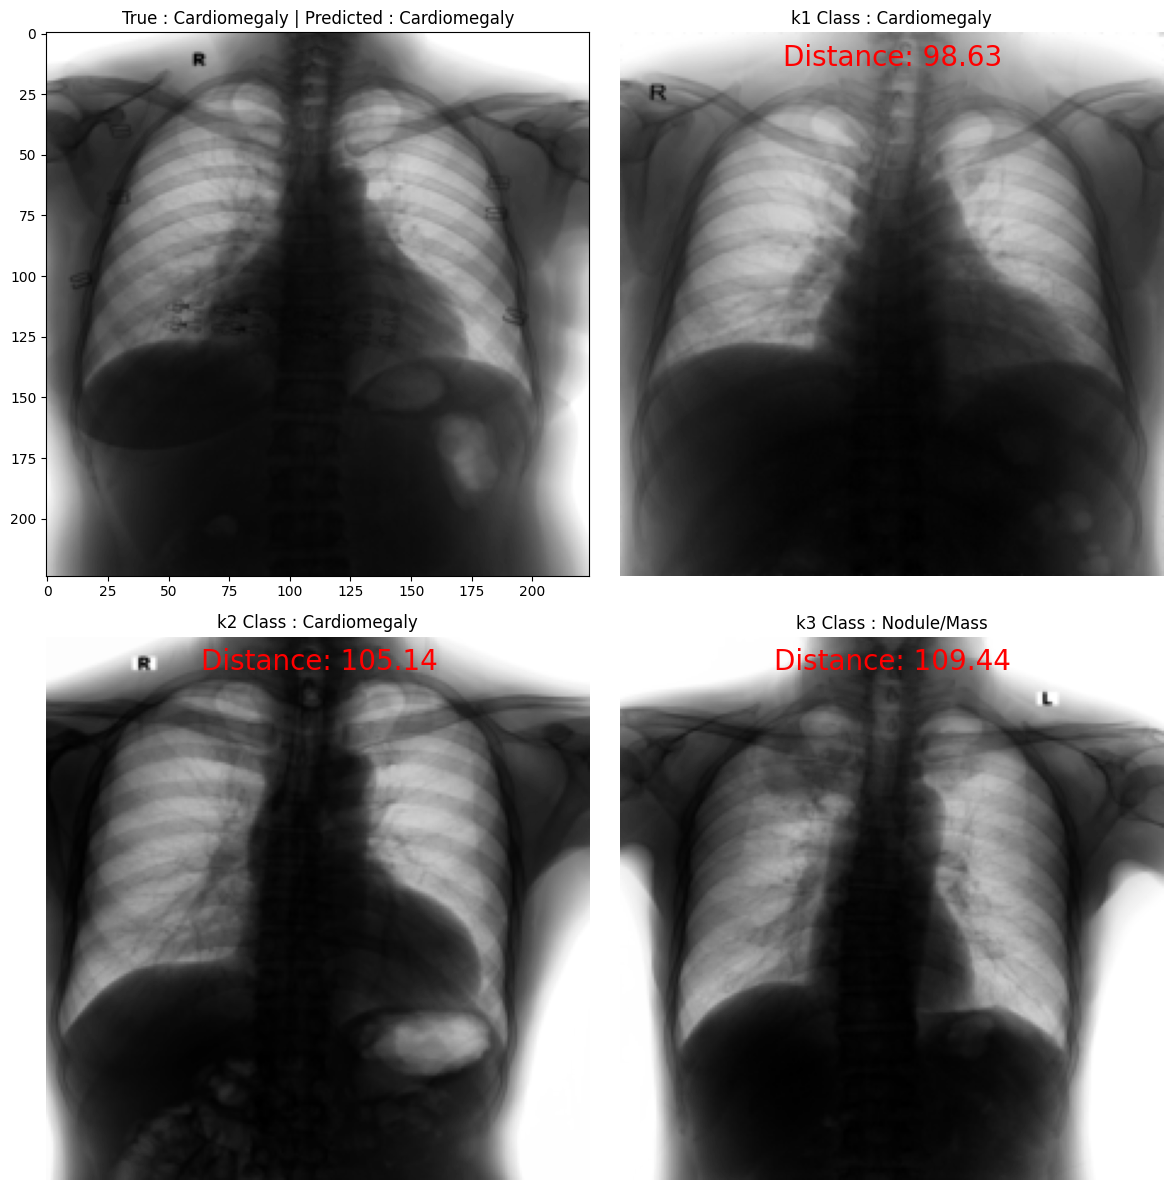

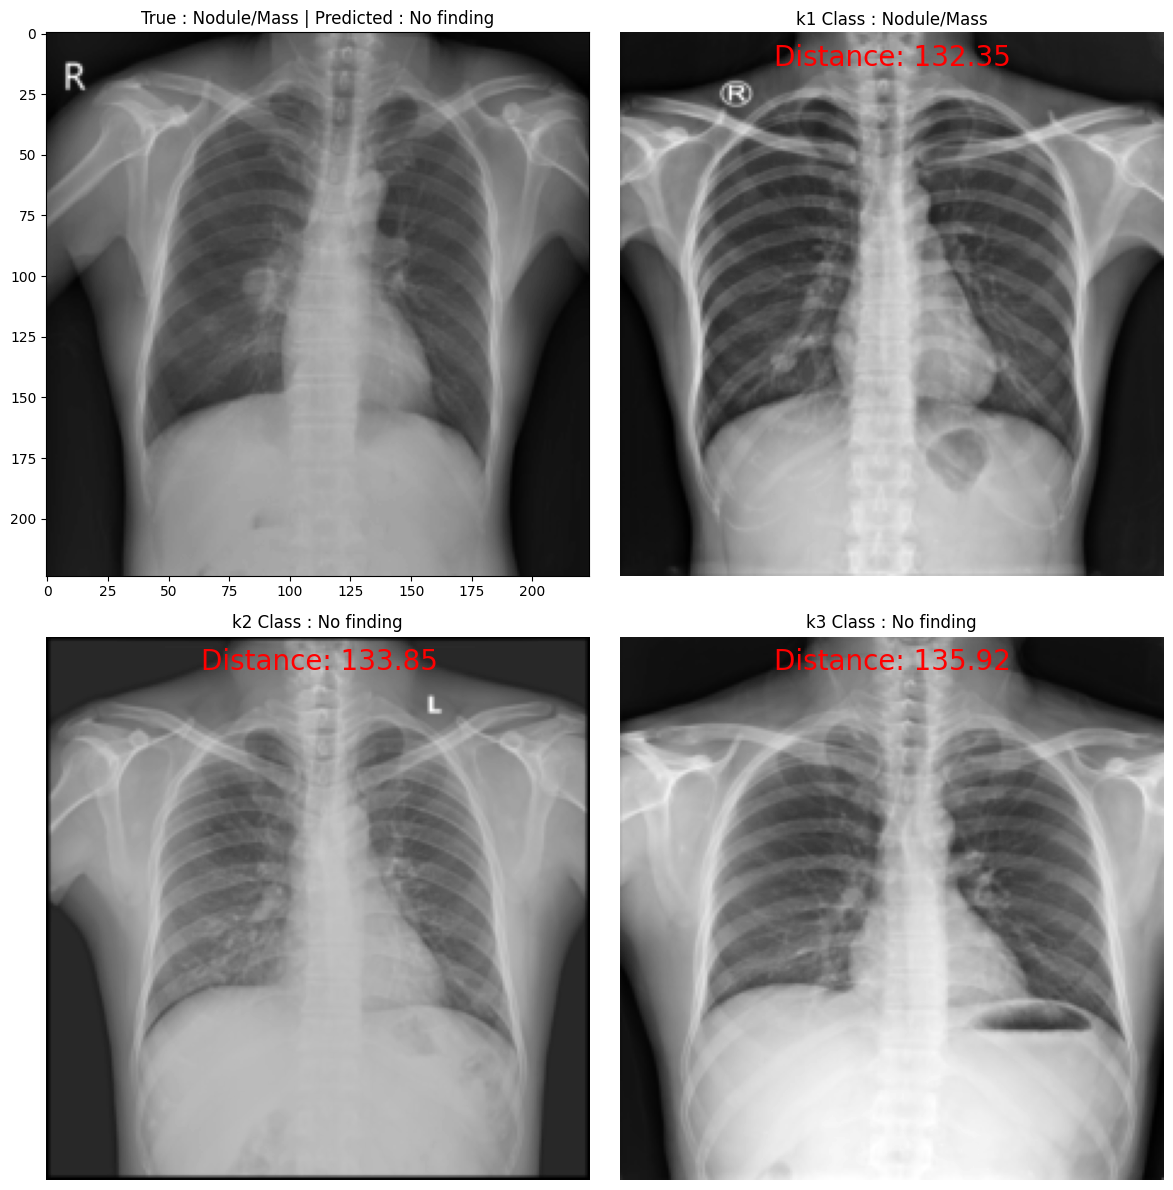

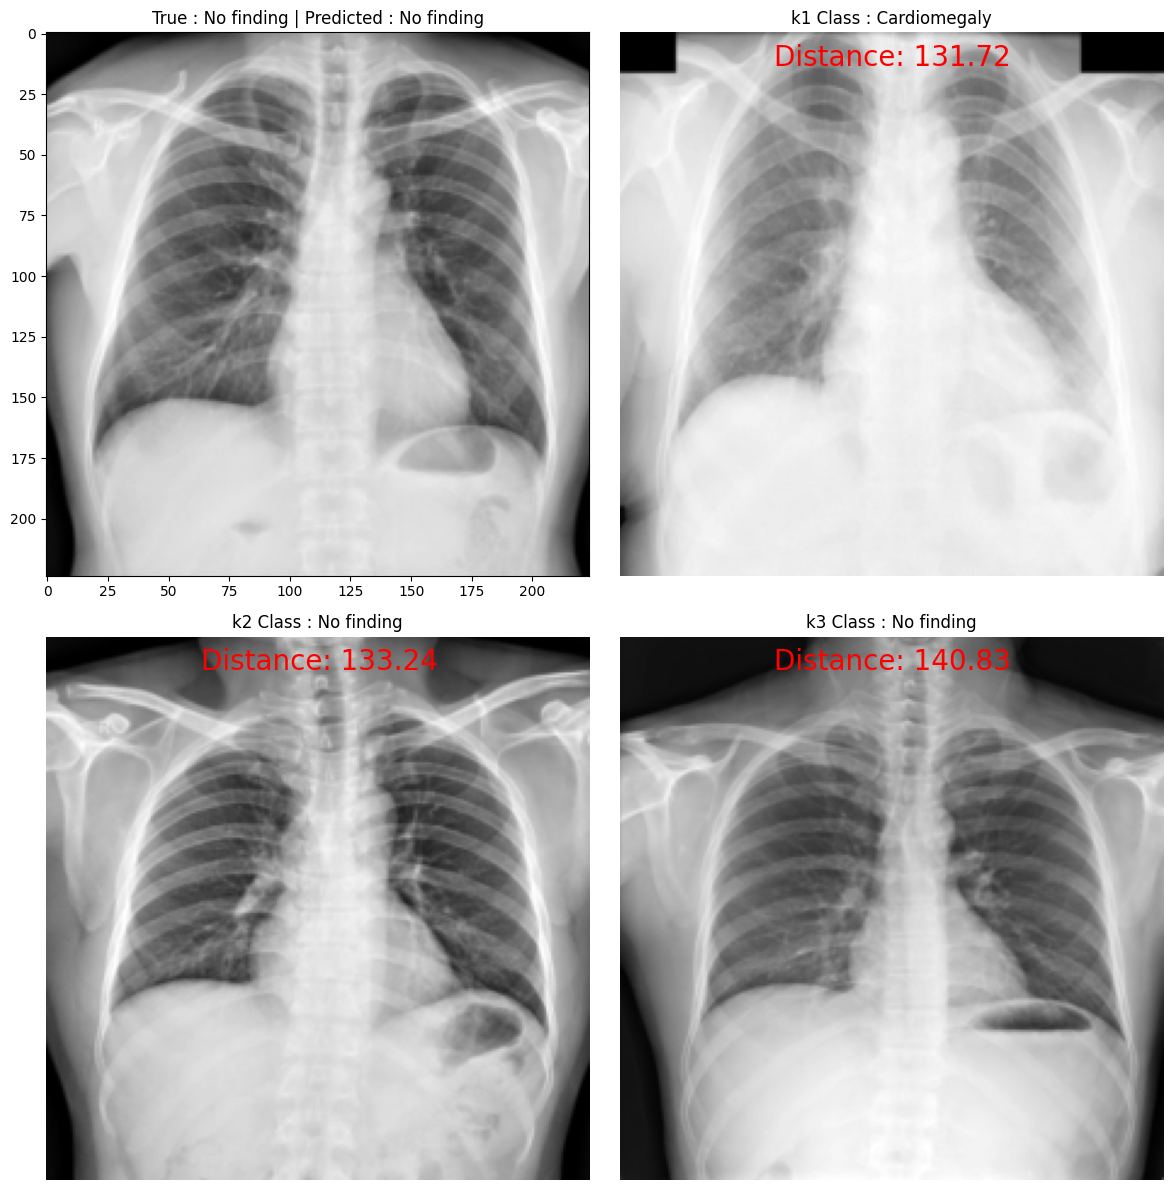

In [37]:
# Imagen de testing que queremos visualizar (0 <= TEST_IMAGE_IDX < N_TEST * len(CLASES)).
# La escogemos aleatoriamente
#TEST_IMAGE_IDX : int = random.randint(0, (N_TEST * len(CLASES)) - 1)

# Visualizamos los resultados de todas las imagenes de testing
for TEST_IMAGE_IDX in range(0, (N_TEST * len(CLASES))):

    # Obtenemos el nombre (path) de una de las imagenes de testing
    test_img_index = list(k_nn_test.keys())[TEST_IMAGE_IDX]

    # La cargamos (sin sus metadatos)
    _, test_img = read_dicom(test_img_index)

    # Creamos una lista donde guardar las k imagenes seleccionadas como mas cercanas a la imagen de test.
    # Vamos rellenandola con las imagenes con sus valores entre 0 y 255 y con una resolucion radiometrica de 8 bits.
    k_images : list[np.ndarray] = []
    for k in range(K):
        _, k_i       = read_dicom(k_nn_test[test_img_index]["k Best"][k])

        k_i = k_i / np.max(k_i)
        k_i = resize(k_i, output_shape=(224, 224), preserve_range=True)
        k_i = (k_i * 255).astype(np.uint8)

        k_images.append(k_i)

    # Normalizamos la imagen de testing
    test_img = test_img / np.max(test_img)
    test_img = resize(test_img, output_shape=(224, 224), preserve_range=True)
    test_img = (test_img * 255).astype(np.uint8)

    # Graficamos los resultados
    plt.figure(figsize=(12,12))

    N_ROWS = K // 2 + 1 
    N_COLS = K // 2 + 1 

    plt.subplot(N_ROWS, N_COLS, 1)
    plt.imshow(test_img, cmap='gray')
    plt.title(f"True : {k_nn_test[test_img_index]['True Class']} | Predicted : {k_nn_test[test_img_index]['Predicted Class']}")

    for k in range(K):

        ax = plt.subplot(N_ROWS, N_COLS, k + 2)
        plt.imshow(k_images[k], cmap='gray')

        # Creamos el texto con la distancia euclidea 
        text : str = f"Distance: {k_nn_test[test_img_index]['k Best Distances'][k]:.2f}"

        # Posicion del texto en cada subplot
        x : int = k_images[k].shape[1] // 2
        y : int = 10

        # COnfiguraciones del texto
        fontsize = 20
        color = 'red'

        # Anadimos el texto
        ax.text(x, y, text, fontsize=fontsize, color=color, ha='center', va='center')

        # Eliminamos ticks y ejes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        plt.title(f"k{k + 1} Class : {k_nn_test[test_img_index]['k Best Classes'][k]}")

    plt.tight_layout()
    plt.show()

### Evaluación cuantitativa de los resultados:

Ahora vamos a ejecutar el algoritmo una cantidad de veces y contaremos cuantas veces hace las predicciones de manera correcta (en particular, obtendremos la ***accuracy*** del modelo para cada clase y en total. Esta se calcula como $accuracy_{A} = \frac{\text{número de ejemplos correctamente clasificados como A}}{\text{clasificaciones donde la respuesta correcta era A}}$). 

Luego, graficaremos los resultados

In [38]:
import matplotlib.pyplot as plt

In [39]:
# Primero, fijamos cuantas veces queremos ejectuar el algoritmo.
# Cuantas mas veces lo hagamos, mejor será la estimación (pero también tardará más)
VAL_STEPS : int = 15

In [40]:
# Empezamos encapsulando el proceso de validacion en una funcion para que sea mas sencillo de utilizar luego
def get_accuracies_for_knn(k         : int,
                           im_path   : str, 
                           extension : str, 
                           df        : pd.DataFrame, 
                           n_test    : int,
                           val_steps : int,
                           model : callable,
                           device : torch.device,
                           clases    : list[str]) -> dict:
    '''
        ===
        Summary
        ===
        Obtiene las accuracies para el algoritmo de k-Nearest Neighbors.

        ===
        Args
        ===
        * k         : Número de vecinos que se tendran en cuenta para asumir que un vector pertenece a una clase 
        * im_path   : ruta a la carpeta donde estan las imagenes (ej. "./imagenes/dsp/")
        * extesnion : extension de las imagenes (ej. ".dsp")
        * df        : Objeto de tipo DataFrame de pandas que contenga dos columnas: "image_id" con el nombre de la imagen, y "class_name" con su clase
        * n_test    : Numero de elementos a considerar como testing
        * model     : Modelo de Deep Learning que usaremos para extraer los vectores de features
        * device    : Dispositivo (cuda o cpu)
        * args      : Nombres de las clases selectas

        ===
        Return
        ===

        Retorna un diccionario de la forma
        k_nn_dict = {
            Class name : accuracy
        }
    '''
    # ********** CONTEO DE EJEMPLOS CORRECTAMENTE CLASIFICADOS ********** #

    # Creamos un diccionario que contenga cuantas veces se ha clasificado correctamente cada clase.
    # Tambien contendra cuantas veces se ha clasificado una imagen de testing correctamente, sin importar la clase
    correctly_classified : dict = {class_name : 0 for class_name in clases}
    correctly_classified["Total"] = 0
    
    # Creamos tambien un diccionario con el numero de clasificaciones hechas por clase.
    # Contara cuantas veces se ha hecho una clasificacion donde la respuesta correcta ("True Class") era una de las keys
    number_of_classifications_performed_per_class : dict = {class_name : 0 for class_name in clases}
    
    # Cargamos el numero de clasificaciones que se van a hacer en total
    number_of_classifications_performed : int = val_steps * (n_test * len(clases)) # Hay n_test * len(clases) imagenes de testing, y cada una se clasifica en un validation step 
    
    # Iteramos tantas veces como steps de validacion hayamos indicado
    for i in range(val_steps):
        print(f"Current validation step: {i + 1} / {val_steps}\n")
    
        # Ejecutamos el algoritmo. Cada vez que se ejecute se escogeran aleatoriamente n_test imagenes de testing
        k_nn_dict : dict = k_nn(k, im_path, extension, df, n_test, model, device, *clases)
    
        # Iteramos por el diccionario obtenido al ejecutar el algoritmo
        for test_img_dict in k_nn_dict.values():
            # Aumentamos en una unidad el numero de clasificaciones hechas por clase
            number_of_classifications_performed_per_class[test_img_dict['True Class']] += 1
    
            # Comprobamos si se ha clasificado correctamente
            if test_img_dict['True Class'] == test_img_dict['Predicted Class']:
                # Aumentamos una unidad el numero de correctly classified total y de la clase particular
                 correctly_classified["Total"] += 1
                 correctly_classified[test_img_dict['True Class']] += 1
    

    # ********** OBTENCION DE ACCURACIES ********** #

    # Una vez contados los ejemplos correctamente clasificados, obtenemos las accuracies (ejemplos correctamente clasficados de clase A / clasificaciones donde la respuesta era clase A)
    accuracies : dict = {}

    # Iteramos por el diccionario de ejemplos clasificados correctamente para extraer las accuracies
    for class_name, num_correctly_classified in correctly_classified.items():
        # Si la clase es "Total", habra que dividir entre number_of_classifications_performed
        if class_name == "Total":
            accuracies["Total"] = num_correctly_classified / number_of_classifications_performed

        # En otro caso, se divide entre number_of_classifications_performed_per_class[class_name]
        else:
            accuracies[class_name] = num_correctly_classified / number_of_classifications_performed_per_class[class_name]

    # Mostramos por pantalla los numeros exactos de las accuracies
    print("----------------- ACCURACIES -----------------\n")
    for class_name, accuracy in accuracies.items():
        print(f"Class {class_name} : {accuracy}\n")

    # Ahora graficamos las accuracies
    keys = list(accuracies.keys())
    values = list(accuracies.values())

    num_bars = len(keys)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

    plt.bar(keys, values, color=colors)

    plt.xlabel('Classes')
    plt.ylabel('Accuracies')
    plt.title('Class vs Accuracy')

    # Rotamos las etiquetas del eje X para mejor visualización
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Devolvemos las accuracies
    return accuracies

Current validation step: 1 / 15

Current validation step: 2 / 15

Current validation step: 3 / 15

Current validation step: 4 / 15

Current validation step: 5 / 15

Current validation step: 6 / 15

Current validation step: 7 / 15

Current validation step: 8 / 15

Current validation step: 9 / 15

Current validation step: 10 / 15

Current validation step: 11 / 15

Current validation step: 12 / 15

Current validation step: 13 / 15

Current validation step: 14 / 15

Current validation step: 15 / 15

----------------- ACCURACIES -----------------

Class Cardiomegaly : 0.6

Class Nodule/Mass : 0.06666666666666667

Class No finding : 0.26666666666666666

Class Total : 0.3111111111111111



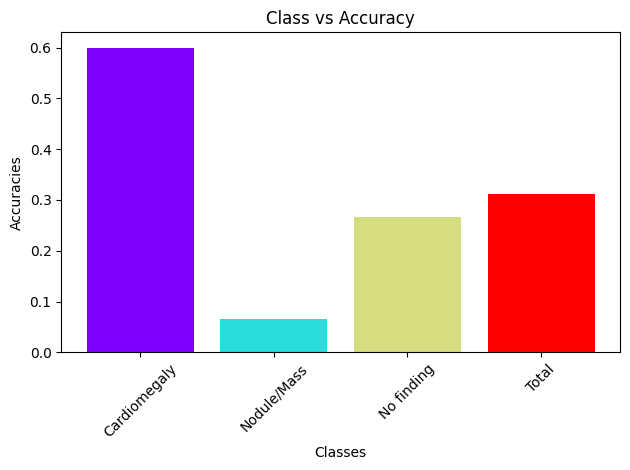

In [41]:
get_accuracies_for_knn(K, IM_PATH, EXTENSION, df, N_TEST, VAL_STEPS, MODEL, DEVICE, CLASES);

### Otra aproximación al problema:

Ahora, vamos a hacer un *finetuning* de la red. Luego probaremos la función *k_nn* con el modelo *fine tuned* y repetiremos el estudio.

In [42]:
import torch

In [43]:
# Empezamos creando un objeto DataSet de Pytorch para nuestras imagenes
class ToraxImagesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 im_path : str, 
                 extension : str, 
                 df : pd.DataFrame, 
                 device : torch.device,
                 *args):
        # Guardamos el argumento
        self.device = device
        
        # Creamos un diccionario que asocie cada clase a su codificacion con one-hot-encoding
        self.class_to_onehot = {
            s: np.eye(len(args))[i]
            for i, s in enumerate(args)
        }

        # Obtenemos un diccionario que asocie la ruta de cada imagen a su clase
        self.path_to_class_dict: dict = {
            f"{im_path}{im_name}{extension}": class_name
            for im_name, class_name in zip(df["image_id"], df["class_name"])
            if class_name in args
        }

        # Creamos una lista con las imagenes como arrays de numpy, y otra con los labels como arrays de numpy
        self.images : list[np.ndarray] = []
        self.labels : list[np.ndarray] = []
        
        for image_full_path, class_name in self.path_to_class_dict.items():
            # Cargamos la imagen
            _, im  = read_dicom(image_full_path)

            # Transformamos los valores de la imagen a valores en el intervalo [0,1]
            im  = im / np.max(im)

            # Le aplicamos un pre-procesado a la imagen para que sea compatible con el modelo
            
            # La re-sizeamos para que sea de 224x224
            im = resize(im, output_shape=(224, 224), preserve_range=True)
            
            # Hacemos que sus entradas vayan de 0 a 255 y con una resolucion radiometrica de 8 bits
            im = (im / np.max(im) * 255).astype(np.uint8)
            im = grayscale_to_rgb(im)
            
            # Movemos las dimensiones de la imagen para que tenga formato channels x width x height 
            im = np.rollaxis(im, 2, 0)
            
            # Permitimos que sus elementos sean floats de 32 bits
            im = im.astype(np.float32)

            # Normalizamos la imagen para que tenga media 0 y varianza 1
            im = im - im.mean()
            im = im / im.std()

            # La convertimos a un tensor de Pytorch
            if self.device.type == 'cuda':
                im = torch.from_numpy(im).float().to('cuda')
            else:
                im = torch.from_numpy(im).float()

            # La anadimos a la lista de imagenes
            self.images.append(im)

            # Ahora obtenemos la clase
            label : np.ndarray = self.class_to_onehot[class_name]

            # La anadimos a la lista de labels
            self.labels.append(label)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.path_to_class_dict.keys())


In [44]:
# Creamos el dataset. Esta vez NO nos interesa dividirlo en test y train porque solo queremos usar las features
torax_dataset : ToraxImagesDataset = ToraxImagesDataset(IM_PATH, EXTENSION, df, device, *CLASES)

In [45]:
# Ahora creamos un dataloader para poder separar en batches
BATCH_SIZE : int = 16
torax_dataloader = torch.utils.data.DataLoader(torax_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
# Descargamos nuevamente el modelo preentrenado (para no afectar al anterior)
finetuned_model = models.vgg16(weights='DEFAULT')

In [47]:
# Printeamos para ver la arquitectura
finetuned_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
from torch import optim

In [49]:
# Congelamos los pesos de las capas iniciales
for param in finetuned_model.features.parameters():
    param.requires_grad = False

# Reemplazamos la capa de clasificacion (La ultima, la fully connected). 
# Esta es la capa a entrenar
num_classes = len(CLASES)  
finetuned_model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes) # in_features es 4096 porque son las in_features de la capa anterior

# Ponemos el modelo en el device
finetuned_model = finetuned_model.to(device)

# Definimos una funcion de coste y un algoritmo de optimizacion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(finetuned_model.parameters(), lr=0.0001)

# Definimos una funcion para entrenar el modelo
def train_model(model : nn.Module, dataloader : torch.utils.data.DataLoader, device : torch.device, num_epochs:int=5) -> list[float]:
    # Se pone al modelo en modo entrenamiento
    model.train()

    # Lista donde guardaremos el running loss por epoca
    running_loss : list[float] = []

    # Iteramos por las epochs
    for epoch in range(num_epochs):

        # Running loss para monitorear el entrenamiento
        running_loss_per_epoch : float = 0.0

        # Iteramos por el dataloader extrayendo los batches
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ponemos los gradientes a cero
            optimizer.zero_grad()

            # Hacemos el forward pass, obtenemos el loss, lo derivamos y actualizamos los pesos
            outputs = finetuned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_per_epoch += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss_per_epoch/len(dataloader)}")
        running_loss.append(running_loss_per_epoch/len(dataloader))
    
    return running_loss

# Entrenamos el modelo
NUM_EPOCHS : int = 50 # Hiperparametro
running_loss : list[float] = train_model(finetuned_model, torax_dataloader, DEVICE, NUM_EPOCHS)

Epoch 1/50, Loss: 1.1667937309082066
Epoch 2/50, Loss: 0.7132234666496515
Epoch 3/50, Loss: 0.5449777769723109
Epoch 4/50, Loss: 0.41421161674328943
Epoch 5/50, Loss: 0.26939238165089463
Epoch 6/50, Loss: 0.23247271950406553
Epoch 7/50, Loss: 0.09319745771582737
Epoch 8/50, Loss: 0.06466288567337738
Epoch 9/50, Loss: 0.040505622727713284
Epoch 10/50, Loss: 0.024349345874465404
Epoch 11/50, Loss: 0.01492696315478627
Epoch 12/50, Loss: 0.009786980209193124
Epoch 13/50, Loss: 0.002748316216704032
Epoch 14/50, Loss: 0.0024039060104509447
Epoch 15/50, Loss: 0.0009857412077524583
Epoch 16/50, Loss: 0.005730566185499291
Epoch 17/50, Loss: 0.0012171994279676873
Epoch 18/50, Loss: 0.000542256245487189
Epoch 19/50, Loss: 0.001551023724258828
Epoch 20/50, Loss: 0.0011316273475987515
Epoch 21/50, Loss: 0.0004448705878290176
Epoch 22/50, Loss: 0.0002888026589939078
Epoch 23/50, Loss: 0.00018411163202155682
Epoch 24/50, Loss: 0.00021570004921349958
Epoch 25/50, Loss: 0.00013603936620500332
Epoch 26/

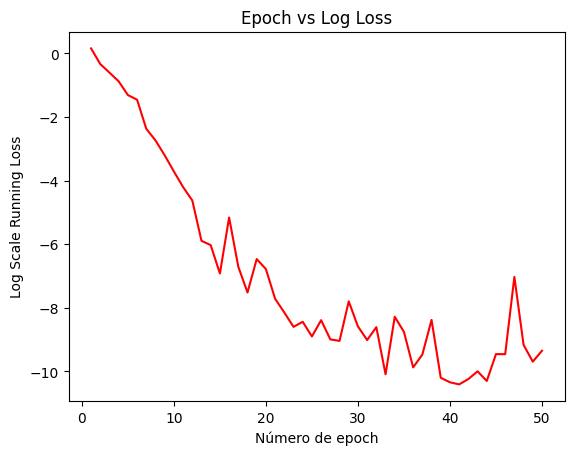

In [50]:
# Graficamos el error en el entrenamiento
plt.plot(list(range(1, len(running_loss) + 1)), np.log(running_loss), color="red")
plt.xlabel("Número de epoch")
plt.ylabel("Log Scale Running Loss")
plt.title("Epoch vs Log Loss")

plt.show()

Finalmente, repetimos el paso de validación pero ahora usamos el modelo *finetuned*

Current validation step: 1 / 15

Current validation step: 2 / 15

Current validation step: 3 / 15

Current validation step: 4 / 15

Current validation step: 5 / 15

Current validation step: 6 / 15

Current validation step: 7 / 15

Current validation step: 8 / 15

Current validation step: 9 / 15

Current validation step: 10 / 15

Current validation step: 11 / 15

Current validation step: 12 / 15

Current validation step: 13 / 15

Current validation step: 14 / 15

Current validation step: 15 / 15

----------------- ACCURACIES -----------------

Class Cardiomegaly : 0.8

Class Nodule/Mass : 0.13333333333333333

Class No finding : 0.06666666666666667

Class Total : 0.3333333333333333



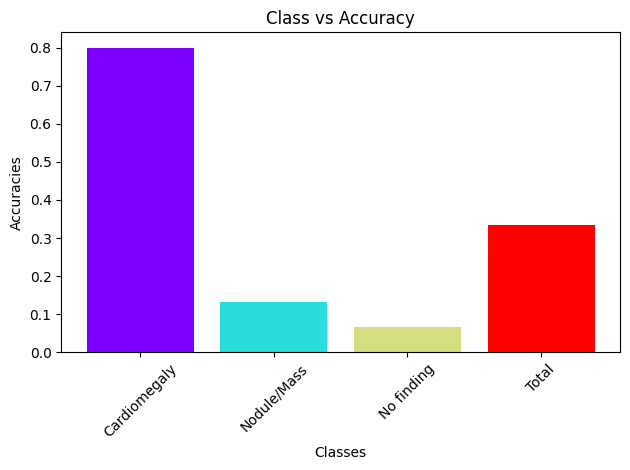

In [51]:
get_accuracies_for_knn(K, IM_PATH, EXTENSION, df, N_TEST, VAL_STEPS, finetuned_model, DEVICE, CLASES);

### Reflexiones finales:

Como se pudo apreciar, a pesar de haber hecho *finetuning* del modelo con unos buenos resultados (el error de entrenamiento decreció considerablemente), se tiene que el *accuracy* total del método de *k-Nearest Neighbors* es parecido (al rededor de un 30% / 40% de *accuracy*) al *accuracy* del algoritmo sobre un modelo sin ajustar.

Aunque es cierto que los vectores de *features* similares deberían ser cercanos entre si en $\mathbb{R}^n$ (siendo $n$ la dimensión del espacio donde "viven" las *features*), este factor de distancia no es el más distintivo a la hora de discriminar las imágenes entre si. De hecho, la red neuronal aprende patrones complejos que finalmente destila en el vector de *features*, pero estos patrones complejos no tienen porqué tener grandes diferencias de distancia. 

Por tanto, aunque el método funcione hasta cierto punto, es un error teorizar sobre posibles "*clusters*" de *features* en el espacio tan altamente dimensional en el que están empotrados estos vectores.

Como última nota (y actualización tras haber presentado este trabajo), puede que el modelo *finetuned* haya sido sobreentrenado y, además, se entrenó con **todo** el dataset. Por tanto, los resultados de validación carecen de validez científica. Ante esto se puede argumentar que realmente no se está usando el modelo, sino sus *features*; el algoritmo que se está validando es otro (el k-Nearest Neighbors).